In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# **Tabla de contenidos**
***
Redes Neuronales (MLP)
1.  Modelo 1 (baseline)

    1.1. Creación del modelo baseline

    1.2. Evaluación del modelo baseline

2.  Modelo 2

    2.1. Creación del modelo 2

    2.2. Evaluación del modelo 2
    
3.  Modelo 3

    3.1. Creación del modelo 3

    3.2. Evaluación del modelo 3

4.  Evaluación general y conclusiones

***

# **Redes Neuronales** (MLP)

Un **modelo MLP** *(perceptrón multicapa)* es una clase de red neuronal que se caracteriza por estar inspirado en las neuronas biológicas y su principal cometido es la **clasificación de datos**.

En nuestro caso vamos a utilizar un modelo MLP para predecir y clasificar **qué tipo de crimen es más posible que le ocurra a una víctima** dependiendo de los siguientes datos:

In [54]:
X_train = pd.read_csv("../../../data/x_train.csv")
X_test = pd.read_csv("../../../data/x_test.csv")
y_train = pd.read_csv("../../../data/y_train.csv")
y_test = pd.read_csv("../../../data/y_test.csv")

Nuestras **variables predictoras** son:

In [55]:
print(f"Variables predictoras:\n")
print(X_train.describe().T)

Variables predictoras:

                                                    count unique    top   freq
ager_18-24                                          44702      2  False  36809
ager_25-34                                          44702      2  False  35387
ager_35-49                                          44702      2  False  33479
ager_50-64                                          44702      2  False  37721
ager_65+                                            44702      2  False  42535
sex_Male                                            44702      2   True  22657
race_ethnicity_Non-Hispanic American Indian/Ala...  44702      2  False  44208
race_ethnicity_Non-Hispanic Asian/Native Hawaii...  44702      2  False  43616
race_ethnicity_Non-Hispanic black                   44702      2  False  39169
race_ethnicity_Non-Hispanic more than one race      44702      2  False  43735
race_ethnicity_Non-Hispanic white                   44702      2   True  30622
hincome1_$25,000 to $34,999 

En este caso la **variable a predecir** seria *'newoff'*:

In [56]:
print(f"Variable a predecir:\n")
print(f"{y_train.info()}\n")
print(f"Valores en la variable a predecir:\n")
print(y_train['newoff'].value_counts())

Variable a predecir:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44702 entries, 0 to 44701
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   newoff  44702 non-null  int64
dtypes: int64(1)
memory usage: 349.4 KB
None

Valores en la variable a predecir:

newoff
4    27850
3     8460
2     4634
1     2440
5     1318
Name: count, dtype: int64


Nuestros DataFrames tiene la siguiente **dimensionalidad**:

In [57]:
print("Dimensionalidad de X_train:", X_train.shape)
print("Dimensionalidad de y_train:", y_train.shape)
print("Dimensionalidad de X_test:", X_test.shape)
print("Dimensionalidad de y_test:", y_test.shape)

Dimensionalidad de X_train: (44702, 47)
Dimensionalidad de y_train: (44702, 1)
Dimensionalidad de X_test: (11176, 47)
Dimensionalidad de y_test: (11176, 1)


Teniendo esto en cuenta podemos hacer las siguientes presunciones:

1. La dimensionalidad de la capa de entrada siempre va a ser:  
$$
n_{\text{features}} = X_{\text{train}}.shape[1]
$$


In [58]:
DIMENS_ENTRADA = (X_train.shape[1],)
print(f"Dimensionalidad de la capa de entrada: {DIMENS_ENTRADA}")

Dimensionalidad de la capa de entrada: (47,)


2. Las capas ocultas utilizarán la función de activación *'ReLU'*:
$$
\text{ReLU}(x) = \max(0, x)
$$


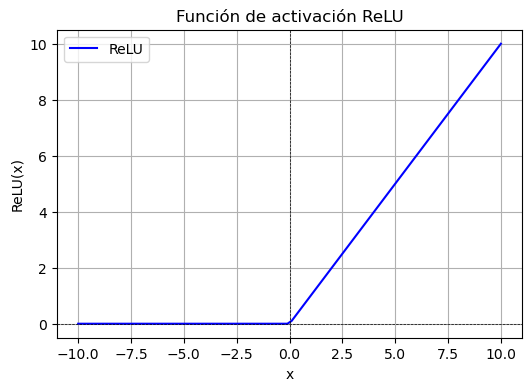

In [59]:
ACT_CAPA_OCULTA = 'relu'

plt.figure(figsize=(6,4))
plt.title("Función de activación ReLU")
x = np.linspace(-10, 10, 100)
y = np.maximum(0, x)
plt.plot(x, y, label='ReLU', color='blue')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.legend()
plt.grid()
plt.show()

3. Como estamos haciendo una red neuronal para clasificación multiclase la función de activación de la capa de salida sera *'Softmax'*:
$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}, \quad i = 1, \dots, K
$$


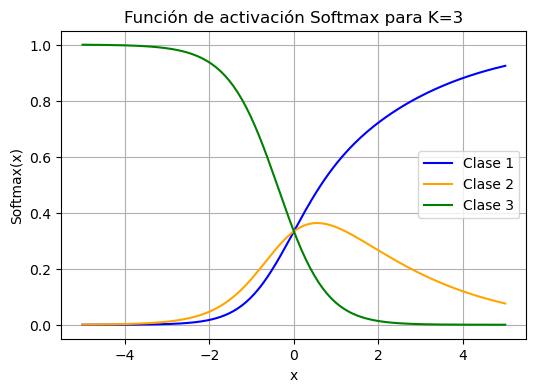

In [60]:
ACT_CAPA_SALIDA = 'softmax'

plt.figure(figsize=(6,4))
plt.title("Función de activación Softmax para K=3")

x = np.linspace(-5, 5, 200)

# Definimos tres "neuronas" con pendientes distintas
z1 = x
z2 = 0.5 * x
z3 = -x

# Calculamos softmax para cada punto x
exp_z = np.exp(np.vstack([z1, z2, z3]))
softmax = exp_z / np.sum(exp_z, axis=0)

# Graficamos
plt.plot(x, softmax[0], label='Clase 1', color='blue')
plt.plot(x, softmax[1], label='Clase 2', color='orange')
plt.plot(x, softmax[2], label='Clase 3', color='green')
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.legend()
plt.grid(True)
plt.show()

4. Como pasamos los resultados en forma de índice y no en OHE la función de pérdida utilizada será la entropía cruzada categórica escasa (*sparse categorical cross-entropy*):
$$
L = -\frac{1}{N} \sum_{i=1}^{N} \log p_{i, y_i}
$$

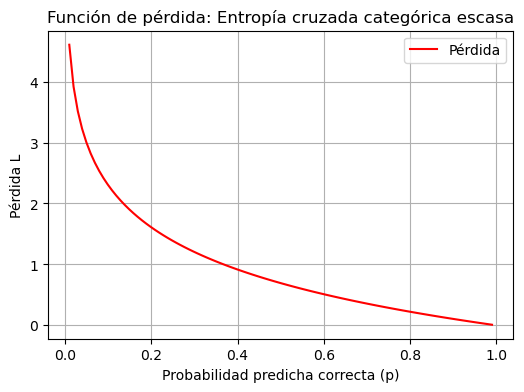

In [61]:
FUNC_PERDIDA = 'sparse_categorical_crossentropy'

plt.figure(figsize=(6,4))
plt.title("Función de pérdida: Entropía cruzada categórica escasa")
p = np.linspace(0.01, 0.99, 100)
L = -np.log(p)
plt.plot(p, L, label='Pérdida', color='red')
plt.xlabel('Probabilidad predicha correcta (p)')
plt.ylabel('Pérdida L')
plt.legend()
plt.grid()
plt.show()

## 1. Explicación modelo baseline

El primer modelo lo vamos a usar como una base para los otros, por esta razón vamos a crearlo con una estructura muy simple.  
En este caso nuestro modelo ***baseline*** se compone de:
- Capa de entrada de dimensionalidad *'(X_train.shape[1])'*
- Capa oculta de *32 neuronas*
- Capa de salida de *6 neuronas*
- *Sin Dropout* entre las capas
- *Sin EarlyStopping*
- Optimizador *'adam'* sin configurar
- Función de perdida *'sparse_categorical_crossentropy'*
- Metricas sobre *'accuracy'*
- Split de validación del *20%*
- *20* épocas
- Batch_size de *32*

### 1.1. Creación modelo baseline


In [84]:
# Modelo simple
model_baseline = Sequential([
    Input(shape=DIMENS_ENTRADA),
    Dense(32, activation=ACT_CAPA_OCULTA),
    Dense(6, activation=ACT_CAPA_SALIDA)
])

model_baseline.compile(optimizer="adam", loss=FUNC_PERDIDA, metrics=["accuracy"])

history_crime = model_baseline.fit(X_train, y_train,
                                   validation_split=0.2,
                                   epochs=20,
                                   batch_size=32,
                                   verbose=1)

Epoch 1/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6128 - loss: 1.0926 - val_accuracy: 0.6268 - val_loss: 1.0467
Epoch 2/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.6226 - loss: 1.0379 - val_accuracy: 0.6276 - val_loss: 1.0338
Epoch 3/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.6236 - loss: 1.0310 - val_accuracy: 0.6268 - val_loss: 1.0321
Epoch 4/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.6249 - loss: 1.0273 - val_accuracy: 0.6278 - val_loss: 1.0320
Epoch 5/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.6250 - loss: 1.0244 - val_accuracy: 0.6277 - val_loss: 1.0281
Epoch 6/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.6255 - loss: 1.0225 - val_accuracy: 0.6268 - val_loss: 1.0281
Epoch 7/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.6260 - loss: 1.0207 - val_accuracy: 0.6283 - val_loss: 1.0296
Epoch 8/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.6255 - l

### 1.2. Evaluación modelo baseline

In [80]:
# Evaluar train

train_loss, train_acc = model_baseline.evaluate(X_train, y_train, verbose=0)

print(f"Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Train Loss: {train_loss:.4f}")

Train Accuracy: 0.6285 (62.85%)
Train Loss: 1.0054


In [81]:
# Evaluar test

test_loss, test_acc = model_baseline.evaluate(X_test, y_test, verbose=0)

print("="*50)
print(" RESULTADOS BASELINE - Tipos crimen")
print("="*50)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*50)

 RESULTADOS BASELINE - Tipos crimen
Test Accuracy: 0.6220 (62.20%)
Test Loss: 1.0370


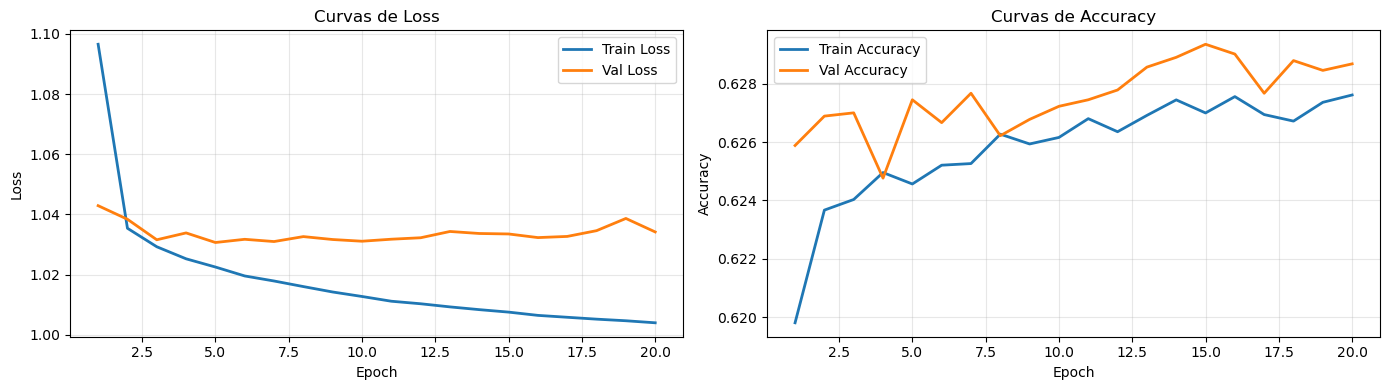

In [82]:
# Visualización de curvas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Crear rango de epochs (1 a 20, no 0 a 19)
epochs = range(1, len(history_crime.history['loss']) + 1)

# Loss
ax1.plot(epochs, history_crime.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs, history_crime.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy
ax2.plot(epochs, history_crime.history['accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(epochs, history_crime.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Curvas de Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


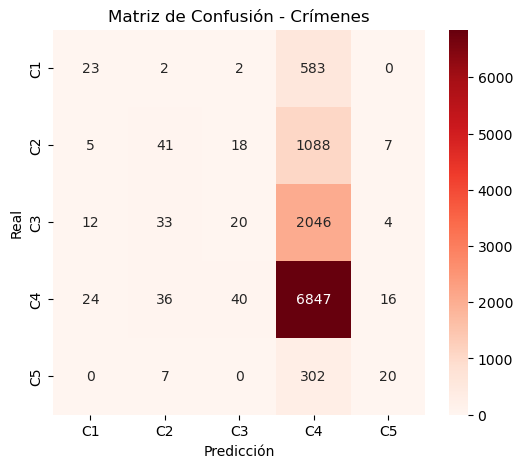


 Classification Report:
              precision    recall  f1-score   support

          C1       0.36      0.04      0.07       610
          C2       0.34      0.04      0.06      1159
          C3       0.25      0.01      0.02      2115
          C4       0.63      0.98      0.77      6963
          C5       0.43      0.06      0.11       329

    accuracy                           0.62     11176
   macro avg       0.40      0.23      0.21     11176
weighted avg       0.51      0.62      0.50     11176



In [83]:
# Matriz de confusión
y_pred_crime = model_baseline.predict(X_test)
y_pred_crime_classes = np.argmax(y_pred_crime, axis=1)

cm = confusion_matrix(y_test, y_pred_crime_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title('Matriz de Confusión - Crímenes')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

print("\n Classification Report:")
print(classification_report(y_test, y_pred_crime_classes, 
                          target_names=[f"C{i+1}" for i in range(5)]))

## 2. Explicación modelo 2

### 2.1. Creación modelo 2

### 2.2. Evaluación modelo 2

## 3. Explicación modelo 3

### 3.1. Creación modelo 3

### 3.2. Evaluación modelo 3

# Evaluación general de todos los modelos